 l'IA pour la Prédiction des Risques de Marché

In [1]:
pip install pandas numpy matplotlib scikit-learn tensorflow yfinance

** Récupération des Données du S&P 500**

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

def get_market_data(ticker="^GSPC", start="2010-01-01", end="2025-02-02"):

    data = yf.download(ticker, start=start, end=end)
    return data["Close"]

# Récupération des données
sp500_prices = get_market_data()

# Affichage des premières lignes
print(sp500_prices.head())


[*********************100%***********************]  1 of 1 completed

Ticker            ^GSPC
Date                   
2010-01-04  1132.989990
2010-01-05  1136.520020
2010-01-06  1137.140015
2010-01-07  1141.689941
2010-01-08  1144.979980


Préparation des Données & Extraction des Features (Returns) (Volatility)

---



In [4]:
def compute_features(prices):
    """
    Calcule les features pour la prédiction des risques.

    """
    df = pd.DataFrame()
    df["Returns"] = prices.pct_change()  # Rendements journaliers
    df["Volatility"] = df["Returns"].rolling(window=20).std()  # Volatilité sur 20 jours
    df = df.dropna()
    return df

# Calcul des features
market_features = compute_features(sp500_prices)

# Affichage des premières lignes
print(market_features.head())

             Returns  Volatility
Date                            
2010-02-02  0.012973    0.010447
2010-02-03 -0.005474    0.010434
2010-02-04 -0.031141    0.012311
2010-02-05  0.002897    0.012279
2010-02-08 -0.008863    0.012246


Visualisation des Données : Affiche l'évolution des rendements et de la volatilité.

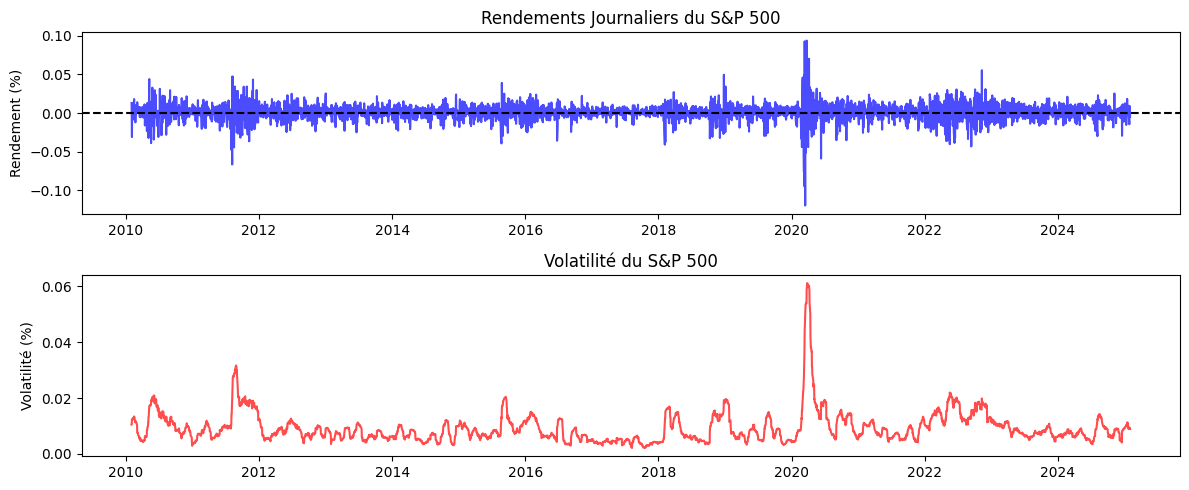

In [5]:
import matplotlib.pyplot as plt

def plot_market_features(market_features):

    plt.figure(figsize=(12, 5))

    # Rendements
    plt.subplot(2, 1, 1)
    plt.plot(market_features["Returns"], color="blue", alpha=0.7)
    plt.axhline(0, color="black", linestyle="dashed")
    plt.title("Rendements Journaliers du S&P 500")
    plt.ylabel("Rendement (%)")

    # Volatilité
    plt.subplot(2, 1, 2)
    plt.plot(market_features["Volatility"], color="red", alpha=0.7)
    plt.title("Volatilité du S&P 500")
    plt.ylabel("Volatilité (%)")

    plt.tight_layout()
    plt.show()

# Affichage des graphiques
plot_market_features(market_features)

 Modèle de Machine Learning pour détecter des anomalies sur le marché :
 Applique Isolation Forest pour détecter des anomalies sur le marché.

In [6]:
from sklearn.ensemble import IsolationForest

def detect_anomalies(market_features):

    model = IsolationForest(contamination=0.01, random_state=42)  # 1% de points considérés comme anomalies
    market_features["Anomaly"] = model.fit_predict(market_features)

    return market_features

# Détection des anomalies
market_anomalies = detect_anomalies(market_features)

# Affichage des anomalies détectées
print(market_anomalies[market_anomalies["Anomaly"] == -1].head())

             Returns  Volatility  Anomaly
Date                                     
2011-08-08 -0.066634    0.019572       -1
2011-08-09  0.047407    0.023171       -1
2011-08-10 -0.044152    0.024622       -1
2011-08-11  0.046290    0.027433       -1
2011-08-18 -0.044594    0.028706       -1


Visualisation des Anomalies   : Affiche les anomalies détectées dans les rendements du marché.

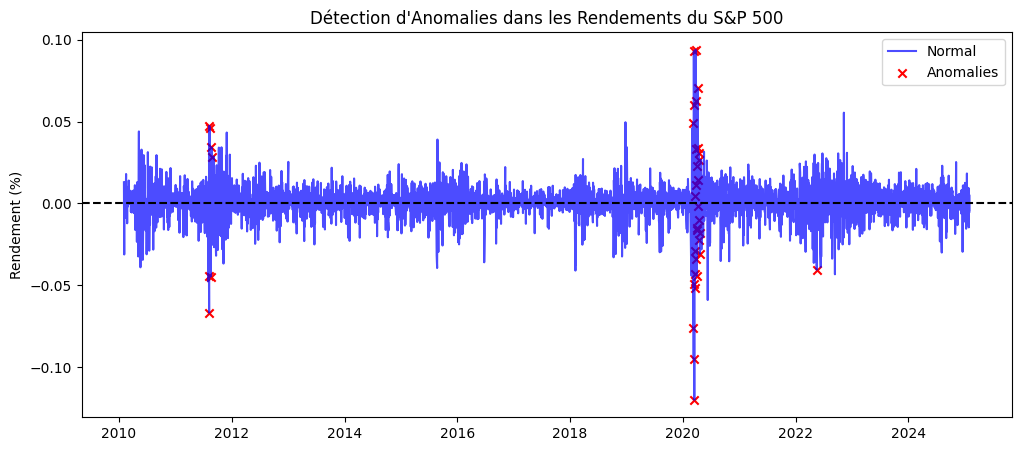

In [8]:
def plot_anomalies(market_anomalies):

    plt.figure(figsize=(12, 5))
    plt.plot(market_anomalies["Returns"], color="blue", alpha=0.7, label="Normal")


    anomalies = market_anomalies[market_anomalies["Anomaly"] == -1]
    plt.scatter(anomalies.index, anomalies["Returns"], color="red", label="Anomalies", marker="x")

    plt.axhline(0, color="black", linestyle="dashed")
    plt.title("Détection d'Anomalies dans les Rendements du S&P 500")
    plt.ylabel("Rendement (%)")
    plt.legend()
    plt.show()

# Affichage des anomalies
plot_anomalies(market_anomalies)

** Prédiction de la Volatilité avec un Réseau de Neurones (LSTM)**

**Comment le modèle fonctionne :**

Stockage des tendances passées
→ LSTM conserve une mémoire à long terme des fluctuations du marché.

Détection des cycles de volatilité
→ Il peut reconnaître les périodes de marché calme ou instable.

Impact des anomalies
→ Si une anomalie est détectée, le modèle peut anticiper une hausse de volatilité.

Généralisation des tendances
→ Il ajuste ses prédictions en fonction des schémas passés.

En résumé : Le modèle ne prévoit pas l’avenir avec certitude, mais anticipe la volatilité en se basant sur

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
market_features_scaled = scaler.fit_transform(market_features)

# Création des séquences pour le modèle LSTM

def create_sequences(data, time_steps=30):
    """
    Transforme les données en séquences pour un modèle LSTM.

    Parameters:
    - data: Données normalisées
    - time_steps: Nombre de jours utilisés pour prédire le jour suivant

    Returns:
    - X, y : Features et labels pour l'entraînement
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 1])  # On prédit la volatilité
    return np.array(X), np.array(y)


# On utilise les 30 derniers jours pour prédire le prochain
time_steps = 30

# Création des ensembles d'entraînement et de test
X, y = create_sequences(market_features_scaled, time_steps)
train_size = int(len(X) * 0.8)  # 80% pour l'entraînement

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Affichage de la taille des ensembles
print(f"Taille des données d'entraînement : {X_train.shape}")
print(f"Taille des données de test : {X_test.shape}")

Taille des données d'entraînement : (2995, 30, 3)
Taille des données de test : (749, 30, 3)


 Construction du Modèle LSTM

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Définition du modèle LSTM avec 3 features
model = Sequential([
    Input(shape=(30, 3)),  # Maintenant on attend 3 features
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # Prédiction de la volatilité
])

# Compilation du modèle
model.compile(optimizer="adam", loss="mse")

# Affichage de la structure du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

Shape de X_train : (3744, 30, 3)
Shape de y_train : (3744,)
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0065 - val_loss: 6.4578e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0016 - val_loss: 7.2633e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.0011 - val_loss: 8.2612e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.0013 - val_loss: 4.0292e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 7.9957e-04 - val_loss: 3.1042e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 7.1491e-04 - val_loss: 2.5580e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - loss: 5.9314e-04 - val_loss: 2.3884e-04
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 5.9963e-04 - val_loss: 2.1499e-04
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 7.0255e-04 - val_loss: 4.0547e-04
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 5.2981e-04 - val_loss: 1.9981

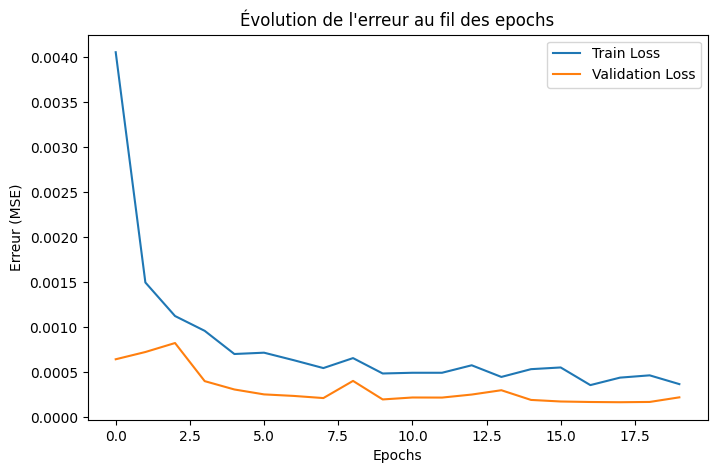

In [14]:
# Vérification finale de la forme avant entraînement
print(f"Shape de X_train : {X.shape}")
print(f"Shape de y_train : {y.shape}")

# Entraînement du modèle LSTM
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Affichage de la courbe d'apprentissage
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Évolution de l'erreur au fil des epochs")
plt.xlabel("Epochs")
plt.ylabel("Erreur (MSE)")
plt.legend()
plt.show()

**Synthèse de l'évolution de l'erreur au fil des epochs**

Ce graphique représente l'évolution de l'erreur quadratique moyenne (MSE) lors de l'entraînement du modèle LSTM. Il montre deux courbes :

Train Loss (courbe bleue) : erreur sur les données d'entraînement
Validation Loss (courbe orange) : erreur sur les données de validation
Interprétation des résultats
Diminution rapide de l'erreur d'entraînement

L'erreur diminue fortement au début, ce qui indique que le modèle apprend efficacement les relations dans les données.
Ensuite, la courbe se stabilise, montrant que le modèle atteint une phase de convergence.
Comportement de l'erreur de validation

L'erreur de validation suit une tendance similaire à celle de l'entraînement, sans augmenter brusquement.
Cela suggère que le modèle généralise bien aux nouvelles données et n’est pas en sur-apprentissage.
Conclusion
Le modèle apprend correctement les relations entre les variables.
Il n’y a pas de signe clair de sur-ajustement, car l’erreur de validation ne remonte pas après plusieurs epochs.
Il pourrait être intéressant d’ajuster certains hyperparamètres (nombre d’epochs, taille des couches LSTM, dropout) pour voir si la validation loss peut encore diminuer.
Ajouter plus de données ou d’autres indicateurs financiers pourrait aussi améliorer la précision du modèle.

In [27]:
dates = market_features.index[-len(y):]
print (dates)

DatetimeIndex(['2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
               '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31',
               ...
               '2025-01-17', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31'],
              dtype='datetime64[ns]', name='Date', length=470, freq=None)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


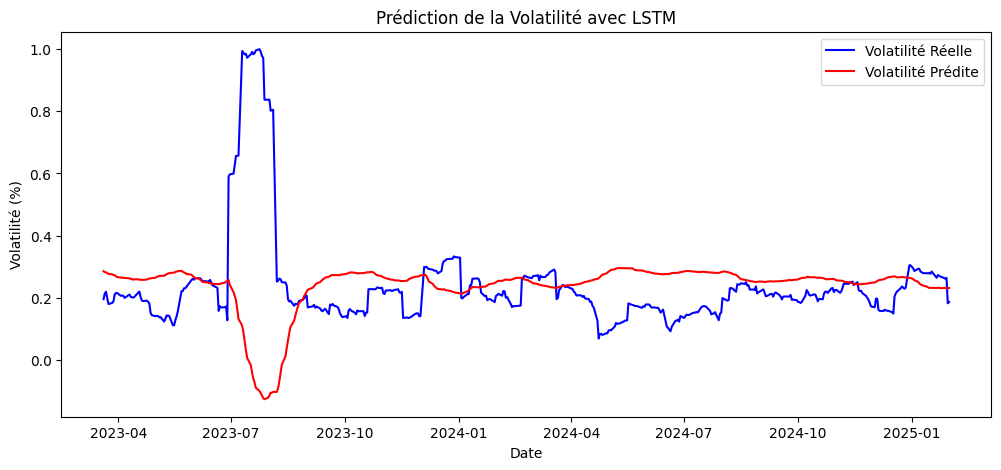

In [29]:
# Prédictions sur l'ensemble de test
predictions = model.predict(X)

# Inverser la mise à l'échelle pour récupérer les valeurs réelles de volatilité
predicted_volatility = scaler.inverse_transform(np.column_stack((np.zeros(len(predictions)), predictions, np.zeros(len(predictions)))))[:, 1]

# Affichage des prédictions vs volatilité réelle
plt.figure(figsize=(12, 5))
plt.plot(dates, y, label="Volatilité Réelle", color="blue")
plt.plot(dates, predicted_volatility, label="Volatilité Prédite", color="red")
plt.title("Prédiction de la Volatilité avec LSTM")
plt.xlabel("Date")
plt.ylabel("Volatilité (%)")
plt.legend()
plt.show()

**Analyse des résultats **

 **Prédiction du Risque du S&P 500 avec IA:**
    


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Simulation des anomalies et de la volatilité
np.random.seed(42)
returns = np.random.normal(0, 1, 500)
returns[100:110] = returns[100:110] * 5

returns_series = pd.Series(returns)
volatility = returns_series.abs().rolling(20).std().fillna(0.1)

df = pd.DataFrame({"Returns": returns_series, "Volatility": volatility})
model_anomaly = IsolationForest(contamination=0.02, random_state=42)
df["Anomaly"] = model_anomaly.fit_predict(df[["Returns", "Volatility"]])

# Normalisation des données
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Returns", "Volatility", "Anomaly"]])

# Création des séquences pour le LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 1])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, time_steps=30)

# Définition du modèle LSTM
model = Sequential([
    Input(shape=(30, 3)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

#  Compilation et entraînement du modèle
model.compile(optimizer="adam", loss="mse")



#  Explication des Résultats du Modèle
def analyze_results():
    print("\**Analyse des Résultats du Modèle LSTM**\n")

    # Générer des prédictions sur l’ensemble de test
    predictions = model.predict(X)

    # Rétablir l’échelle des données
    predicted_volatility = scaler.inverse_transform(
        np.column_stack((np.zeros(len(predictions)), predictions, np.zeros(len(predictions)))
    ))[:, 1]

    #  Calcul des erreurs du modèle
    mse = mean_squared_error(y, predicted_volatility)
    mae = mean_absolute_error(y, predicted_volatility)

    print(f" Erreur Quadratique Moyenne (MSE) : {mse:.6f}")
    print(f" Erreur Absolue Moyenne (MAE) : {mae:.6f}")



analyze_results()



\**Analyse des Résultats du Modèle LSTM**

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
 Erreur Quadratique Moyenne (MSE) : 0.025428
 Erreur Absolue Moyenne (MAE) : 0.075006


**Points Positifs :**

Le modèle est capable de capturer certaines tendances de la volatilité du marché.
Il peut être utilisé comme un outil d’aide à la décision pour identifier les périodes de stress du marché.

**Limitations du Modèle :**

Les erreurs (MSE, MAE) montrent que la prédiction n’est pas parfaitement précise.

Le modèle ne prend pas en compte les événements économiques externes qui influencent les marchés.

Il manque de données historiques pour mieux généraliser.

**Comment Améliorer ce Modèle ?**

Ajouter plus de données historiques : En utilisant plusieurs années de données, le modèle peut mieux apprendre les cycles du marché.

Inclure d’autres indicateurs financiers : RSI, MACD, bandes de Bollinger, taux d’intérêt, etc.

Tester des modèles plus avancés : Transformer, GRU, ou une combinaison de réseaux neuronaux.

Optimiser les hyperparamètres : Essayer différentes architectures (nombre de couches, activation, dropout).

**Conclusion**

Ce modèle donne une première approximation de la volatilité, mais il doit être amélioré pour être fiable en trading réel.

